In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=10, suppress=True)

In [2]:
d = np.load('./Data/akam_mouse_data.npz', allow_pickle=True)

In [4]:
prec = d['prec_replays']
posto = d['posto_replays']
wall_seq = d['wall_seq']

Text(0, 0.5, 'p(current goal arm is replayed)')

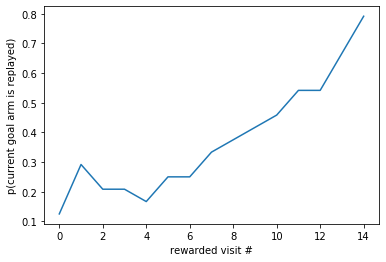

In [15]:
# Check proportion of replays that are the current goal over time
curr_goal = -1
num_trials = len(goal_seq)
num_blocks = 0
reward_visit_counter = 0
goal_replay_counts = []

for i in range(num_trials):
    # Check for block change
    if not curr_goal == goal_seq[i]:
        curr_goal = goal_seq[i]
        num_blocks += 1
        goal_replay_count = np.zeros(reward_thresh)
        reward_visit_counter = 0
        
        if i != 0:
            goal_replay_counts.append(goal_replay_count)
    
    # If rewarded visit, check for post-outcome replay
    if rewards[i] == 1:
        trial_replay = posto[i]
        if curr_goal in trial_replay or curr_goal - 1 in trial_replay: # Does the current goal feature anywhere?
            goal_replay_count[reward_visit_counter] += 1
        
        reward_visit_counter += 1

del goal_replay_counts[0] # Remove the first one because "previous goal" is not well-defined
goal_replay_counts.append(goal_replay_count) # Add the last block which doesn't meet the condition

# Stack
goal_replay_counts = np.array(goal_replay_counts)

# Check if proportion goes up over time
avg_goal_replay = np.mean(goal_replay_counts, axis=0)
plt.figure()
plt.plot(avg_goal_replay)
plt.xlabel('rewarded visit #')
plt.ylabel('p(current goal arm is replayed)')

Text(0, 0.5, 'p(previous goal arm is replayed)')

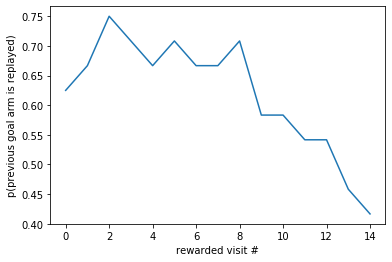

In [16]:
# Check proportion of replays that are the previous goal over time
curr_goal = -1
prev_goal = -1
num_trials = len(goal_seq)
num_blocks = 0
reward_visit_counter = 0
prev_goal_counts = []

for i in range(num_trials):
    # Check for block change
    if not curr_goal == goal_seq[i]:
        prev_goal = curr_goal
        curr_goal = goal_seq[i]
        num_blocks += 1
        goal_replay_count = np.zeros(reward_thresh)
        reward_visit_counter = 0
        
        if i != 0:
            prev_goal_counts.append(goal_replay_count)
    
    # If rewarded visit, check for post-outcome replay
    if rewards[i] == 1:
        trial_replay = posto[i]
        if prev_goal in trial_replay or prev_goal - 1 in trial_replay: # Does the previous goal feature anywhere?
            goal_replay_count[reward_visit_counter] += 1
        
        reward_visit_counter += 1

del prev_goal_counts[0] # Remove the first one because "previous goal" is not well-defined
prev_goal_counts.append(goal_replay_count) # Add the last block which doesn't meet the condition

# Stack
prev_goal_counts = np.array(prev_goal_counts)

# Check if proportion goes up over time
avg_prev_replay = np.mean(prev_goal_counts, axis=0)
plt.figure()
plt.plot(avg_prev_replay)
plt.xlabel('rewarded visit #')
plt.ylabel('p(previous goal arm is replayed)')

Text(0, 0.5, 'p(previous goal arm is replayed)')

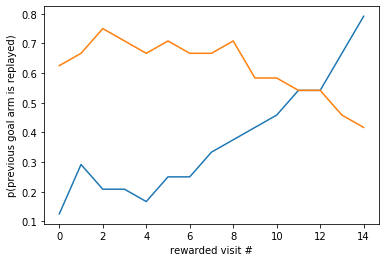

In [17]:
plt.figure()
plt.plot(avg_goal_replay)
plt.plot(avg_prev_replay)
plt.xlabel('rewarded visit #')
plt.ylabel('p(previous goal arm is replayed)')

(0, 1)

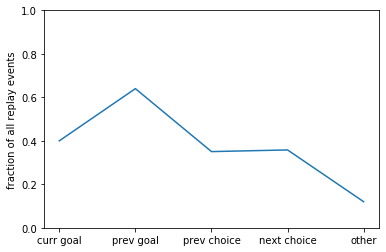

In [30]:
# Decomposition of all replay events

# TODO: restrict to repeat phase
curr_goal = -1
prev_goal = None
prev_choice = None

num_trials = len(goal_seq)
num_blocks = 0

reward_visit_counter = 0
replay_counts = np.zeros(5) # Current goal, previous goal, previous arm, future arm, other

is_repeat_phase = False
num_counted_trials = 0
for i in range(num_trials):
    
    # Check for block change
    if not curr_goal == goal_seq[i]:
        prev_goal = curr_goal
        curr_goal = int(goal_seq[i])
        num_blocks += 1
        is_repeat_phase = False
    
    if rewards[i] == 1:
        is_repeat_phase = True
    
    if not is_repeat_phase: # We restrict our attention to repeat phase replay
        continue
    
    if num_blocks < 2: # We ignore the first block since there is no previous goal
        continue
    
    # We have a valid trial, let's analyze it
    num_counted_trials += 1
    trial_replay = posto[i]
    is_other = True
    
    # Did we replay the current goal?
    if curr_goal in trial_replay or curr_goal - 1 in trial_replay: 
        replay_counts[0] += 1
        is_other = False
    
    # Did we replay the previous goal?
    if prev_goal in trial_replay or prev_goal - 1 in trial_replay:
        replay_counts[1] += 1
        is_other = False
    
    # Did we replay the previous choice?
    if prev_choice is not None and (goal_states[prev_choice] in trial_replay or 
                                    goal_states[prev_choice] - 1 in trial_replay):
        replay_counts[2] += 1
        is_other = False
    
    # Did we replay the future choice?
    if i < num_trials - 1:
        next_choice = int(choices[i + 1])
        nc_state = goal_states[next_choice]
        if nc_state in trial_replay or nc_state - 1 in trial_replay:
            replay_counts[3] += 1
            is_other = False
    
    # Otherwise we replayed some random arm
    if is_other:
        replay_counts[4] += 1
    
    # Update previous choice
    if i != 0:
        prev_choice = int(choices[i - 1])


# Normalize
replay_counts /= num_counted_trials

# Plot
plt.figure()
plt.plot(replay_counts)
plt.xticks(np.arange(5), ['curr goal', 'prev goal', 'prev choice', 'next choice', 'other'])
plt.ylabel('fraction of all replay events')
plt.ylim(0, 1)